In [1]:
!pip install snntorch mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 95.3 MB/s eta 0:00:00


Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 01m24s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
Setting channel info structure...
Creating raw.info structure...
Re

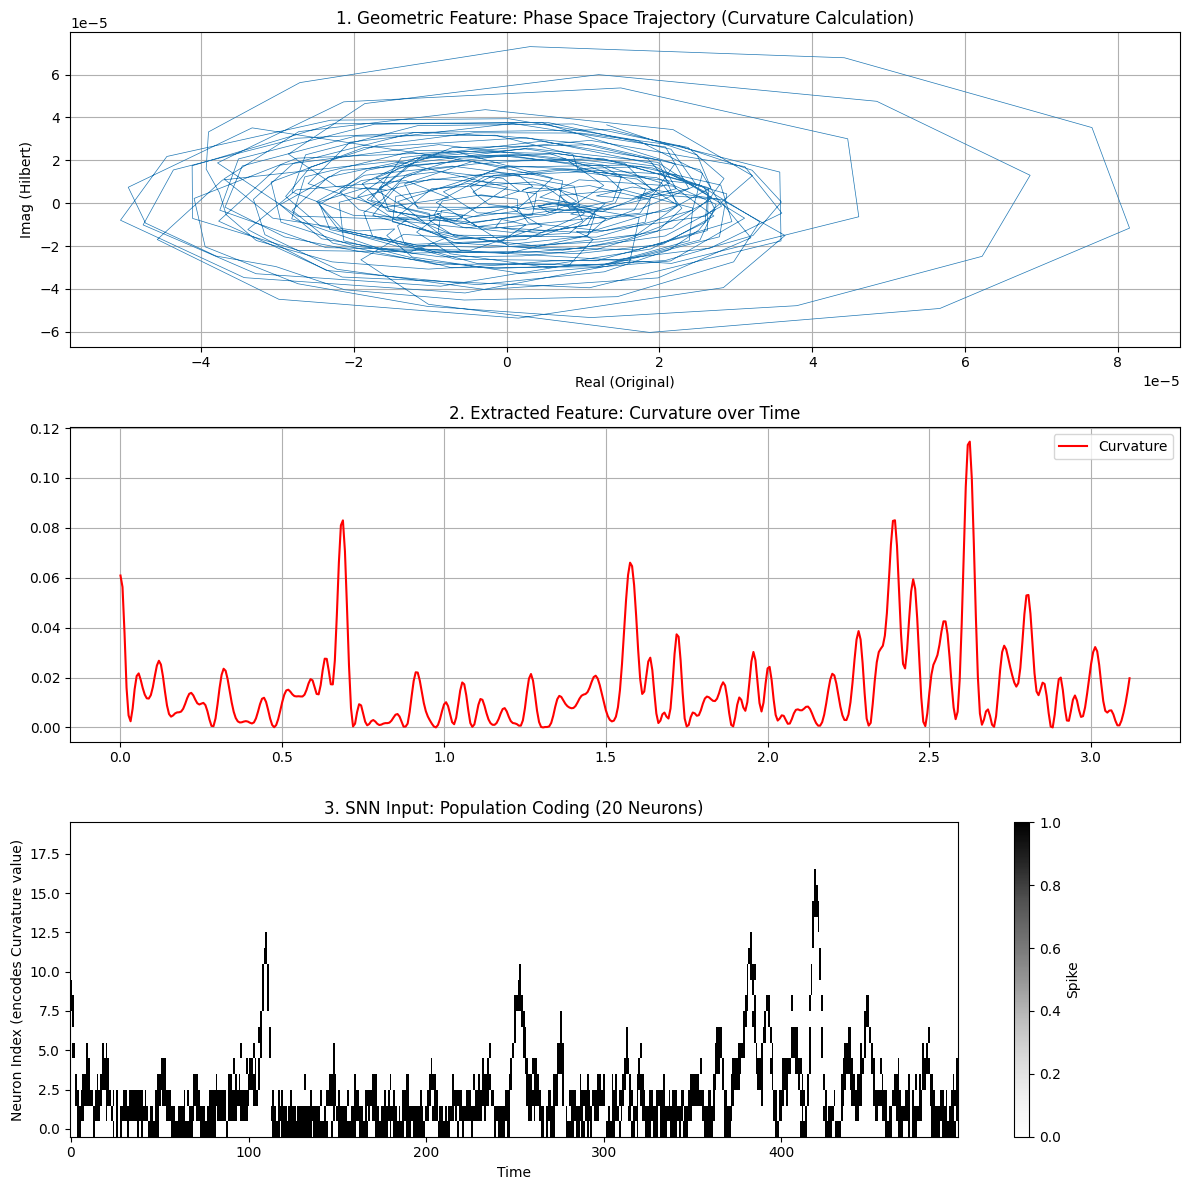

In [ ]:
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate

# ==========================================
# 1. 데이터 로드 (기존 코드 유지)
# ==========================================
subject = 1
runs = [4, 8, 12] # Motor Imagery Task

# 데이터 다운로드 및 로드
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_fnames])

# 표준화 및 채널 선택
eegbci.standardize(raw)
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)
target_channels = ['C3'] # 데모를 위해 C3 하나만 집중 분석
raw.pick_channels(target_channels)

# 필터링 (8-30Hz)
raw.filter(8., 30., fir_design='firwin', skip_by_annotation='edge')

# 데이터 추출 (C3 채널)
data, times = raw[: , :1000] # 앞부분 1000개 샘플만 사용 (테스트용)
c3_signal = data[0]

# ==========================================
# 2. [Novelty] 기하학적 특징 추출 (Curvature)
# ==========================================
# 설명: 힐베르트 변환을 통해 위상 공간(Phase Space) 궤적을 만들고,
# 그 궤적의 '휘어짐 정도(곡률)'를 계산해서 특징으로 사용함.

def get_curvature(signal):
    # 1. 힐베르트 변환 (Analytic Signal)
    analytic = hilbert(signal)
    x = np.real(analytic) # 원신호
    y = np.imag(analytic) # 90도 위상 지연 신호

    # 2. 미분 (중심 차분법 사용)
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    # 3. 곡률(Curvature) 공식: k = |x'y'' - y'x''| / (x'^2 + y'^2)^(1.5)
    numerator = np.abs(dx * ddy - dy * ddx)
    denominator = np.power(dx**2 + dy**2, 1.5) + 1e-8 # 0 나누기 방지

    curvature = numerator / denominator
    return curvature, x, y

# 곡률 계산 수행
curvature_feature, x_traj, y_traj = get_curvature(c3_signal)

# [중요] 인코딩을 위해 정규화 (0~1 사이로 맞춤)
curv_norm = (curvature_feature - curvature_feature.min()) / (curvature_feature.max() - curvature_feature.min())

# ==========================================
# 3. [Novelty] Population Coding (Gaussian Receptive Fields)
# ==========================================
# 설명: 하나의 곡률 값(스칼라)을 N개의 뉴런 활성도(벡터)로 변환
# 값이 0.1이면 1번 뉴런이, 0.9면 N번 뉴런이 반응하도록 설계

def gaussian_population_coding(norm_data, num_neurons=20, max_freq=1.0):
    """
    norm_data: 0~1로 정규화된 시계열 데이터 [Time]
    num_neurons: 값을 표현할 뉴런의 개수 (해상도)
    """
    time_steps = len(norm_data)

    # 각 뉴런이 담당하는 중심 값 (0부터 1까지 등간격 배치)
    mu = np.linspace(0, 1, num_neurons)
    sigma = 1.0 / num_neurons # 각 뉴런의 수용 영역(Receptive Field) 폭

    spike_train = []

    for t in range(time_steps):
        val = norm_data[t]

        # 가우시안 함수로 각 뉴런의 반응 확률 계산
        response_probs = np.exp(-((mu - val)**2) / (2 * sigma**2))

        # 확률에 기반하여 베르누이 시행 -> 스파이크 생성 (0 or 1)
        # torch.bernoulli를 쓰기 위해 텐서로 변환
        probs_tensor = torch.tensor(response_probs, dtype=torch.float)
        spikes = torch.bernoulli(probs_tensor * max_freq) # max_freq는 발화 강도 조절

        spike_train.append(spikes)

    return torch.stack(spike_train) # Shape: [Time, Num_Neurons]

# 인코딩 수행 (20개의 뉴런이 곡률 값을 나누어 표현)
num_encoding_neurons = 20
encoded_spikes = gaussian_population_coding(curv_norm, num_neurons=num_encoding_neurons)

# 모델 입력을 위해 배치 차원 추가: [Batch, Time, Channels(Neurons)]
# 여기서는 Batch=1, Channels=num_encoding_neurons
input_tensor = encoded_spikes.unsqueeze(0) # [1, 1000, 20]

# ==========================================
# 4. SNN 모델 정의 (snnTorch)
# ==========================================
# 너의 의도: 인코딩된 스파이크들이 모델 내부에서 처리됨

class GeometricSNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_classes):
        super().__init__()

        beta = 0.9 # 막전위 감쇠율
        spike_grad = surrogate.fast_sigmoid() # 역전파용 대리 기울기

        # Layer 1: 인코딩된 뉴런들의 패턴을 읽음 (Temporal Convolution)
        self.conv1 = nn.Conv1d(in_channels=num_inputs, out_channels=32, kernel_size=5, padding=2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        # Layer 2: 특징 추출 심화
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        # Output Layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, num_classes)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, output=True)

    def forward(self, x):
        # x shape: [Batch, Time, Input_Neurons] -> Conv1d를 위해 [Batch, Input_Neurons, Time]으로 변경 필요
        # 하지만 SNN은 Time loop를 돌아야 하므로, 매 step마다 처리하거나
        # Conv1d를 먼저 전체 시간축에 대해 수행하고 SNN에 넣는 방식이 효율적임.

        # 여기서는 효율성을 위해 "Conv 전체 수행 후 -> LIF에 순차 주입" 방식 사용
        x = x.permute(0, 2, 1) # [Batch, Input_Neurons, Time]

        # 1. Conv 연산 (전체 시간축에 대해 한방에)
        c1 = self.conv1(x) # [Batch, 32, Time]
        c2 = self.conv2(torch.relu(c1)) # [Batch, 64, Time] (Activation 겸용)

        # 2. SNN 시뮬레이션 (Time-step Loop)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []

        # 시간축 길이만큼 루프
        time_steps = x.size(2)

        for step in range(time_steps):
            # 현재 시점의 Conv feature 가져오기
            cur_input = c2[:, :, step] # [Batch, 64]

            # SNN Layer 통과
            spk2, mem2 = self.lif2(cur_input, mem2) # LIF

            # Output
            cur_out = self.fc(spk2)
            spk3, mem3 = self.lif3(cur_out, mem3)

            spk3_rec.append(spk3)

        return torch.stack(spk3_rec, dim=0)

# 모델 초기화
model = GeometricSNN(num_inputs=num_encoding_neurons, num_hidden=64, num_classes=4)

# Forward Pass 테스트
output_spikes = model(input_tensor)
print(f"Input Shape: {input_tensor.shape} (Batch, Time, Input_Neurons)")
print(f"Output Shape: {output_spikes.shape} (Time, Batch, Classes)")

# ==========================================
# 5. 시각화: 기하학적 특징 & 인코딩 결과
# ==========================================
plt.figure(figsize=(12, 12))

# 1. 위상 공간 궤적 (Phase Portrait)
plt.subplot(3, 1, 1)
plt.title(f"1. Geometric Feature: Phase Space Trajectory (Curvature Calculation)")
plt.plot(x_traj[:500], y_traj[:500], lw=0.5)
plt.xlabel("Real (Original)")
plt.ylabel("Imag (Hilbert)")
plt.grid(True)

# 2. 곡률 변화 (Curvature over Time)
plt.subplot(3, 1, 2)
plt.title("2. Extracted Feature: Curvature over Time")
plt.plot(times[:500], curvature_feature[:500], 'r', label='Curvature')
plt.legend()
plt.grid(True)

# 3. Population Coding (Spike Raster Plot)
plt.subplot(3, 1, 3)
plt.title(f"3. SNN Input: Population Coding ({num_encoding_neurons} Neurons)")
spike_data = encoded_spikes.numpy().T # [Neurons, Time]
plt.imshow(spike_data[:, :500], aspect='auto', cmap='Greys', interpolation='nearest', origin='lower')
plt.xlabel("Time")
plt.ylabel("Neuron Index (encodes Curvature value)")
plt.colorbar(label="Spike")

plt.tight_layout()
plt.show()


In [ ]:
import mne
from mne.datasets import eegbci
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from scipy.signal import hilbert

# ==========================================
# 1. 데이터 로드 및 에포크(Epoch) 생성
# ==========================================
print(">>> 데이터 로드 중...")
subject = 1
runs = [4, 8, 12]  # Motor Imagery: Left vs Right Fist

# 데이터 로드
raw_fnames = eegbci.load_data(subject, runs)
raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)

# ==========================================
# (수정됨) 이벤트(라벨) 추출 파트
# ==========================================

# 1. 우리가 원하는 라벨 매핑을 미리 정의 (T1: 왼손, T2: 오른손)
# PhysioNet 데이터에서 T1, T2 문자열을 우리가 원하는 숫자(0, 1)로 강제 매핑
event_id = dict(T1=0, T2=1)

# 2. events_from_annotations 함수에 event_id를 인자로 넘겨줌
# 이렇게 하면 T1은 0으로, T2는 1로 변환되어 events 배열에 저장됨 (T0 등 다른건 무시됨)
events, _ = mne.events_from_annotations(raw, event_id=event_id)

print(f">>> 추출된 이벤트 개수: {len(events)}")
print(f">>> 이벤트 ID 확인: {event_id}")

# 3. Epochs로 자르기
# 이제 events 배열 안에 0과 1이 들어있으므로 에러가 안 남
epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=3, baseline=None, preload=True)

# 라벨 추출 (이미 0과 1로 되어있지만 확인차)
labels = epochs.events[:, -1]

# 8-30Hz 필터링 (Alpha/Beta 파)
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

# Epochs로 자르기 (이벤트 발생 후 0초~3초 데이터)
epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=3, baseline=None, preload=True)
labels = epochs.events[:, -1] - min(epochs.events[:, -1]) # 0, 1로 라벨 정규화

# C3, C4 채널 데이터만 추출 (좌/우 운동 피질)
# shape: [Trials, Channels(2), Time]
data = epochs.pick_channels(['C3', 'C4']).get_data()
print(f">>> 데이터 준비 완료. Shape: {data.shape}")

# ==========================================
# 2. [Feature Extraction] 기하학적 곡률 + 인코딩
# ==========================================
def get_curvature_batch(signals):
    """
    배치 단위로 곡률 계산
    signals: [Time] (단일 채널 시계열)
    """
    analytic = hilbert(signals)
    x = np.real(analytic)
    y = np.imag(analytic)

    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    numerator = np.abs(dx * ddy - dy * ddx)
    denominator = np.power(dx**2 + dy**2, 1.5) + 1e-8
    return numerator / denominator

def encode_dataset(data_tensor, num_neurons=20):
    """
    전체 데이터셋을 순회하며 곡률 계산 및 스파이크 인코딩
    data_tensor: [Trials, Channels, Time]
    """
    encoded_list = []

    print(">>> 특징 추출 및 스파이크 인코딩 진행 중...")
    for i in range(len(data_tensor)): # 각 Trial 별로 수행
        trial_spikes = []
        for ch in range(data_tensor.shape[1]): # 채널별(C3, C4) 반복
            # 1. 곡률 계산
            curv = get_curvature_batch(data_tensor[i, ch])
            # 정규화 (Trial 별로)
            curv_norm = (curv - curv.min()) / (curv.max() - curv.min() + 1e-8)

            # 2. Population Coding
            # 미리 정의한 Gaussian Coding 로직 적용
            mu = np.linspace(0, 1, num_neurons)
            sigma = 1.0 / num_neurons

            # 벡터화된 연산으로 속도 향상
            # curv_norm: [Time], mu: [Neurons] -> Broadcasting
            # [Time, 1] - [1, Neurons] = [Time, Neurons]
            diff = curv_norm[:, np.newaxis] - mu[np.newaxis, :]
            probs = np.exp(-(diff**2) / (2 * sigma**2))

            spikes = torch.bernoulli(torch.tensor(probs, dtype=torch.float))
            trial_spikes.append(spikes) # [Time, Neurons]

        # C3, C4의 스파이크를 채널 차원으로 합침 (Concatenate)
        # 결과: [Time, Neurons * 2] -> C3용 20개 + C4용 20개 = 총 40개 입력
        combined_spikes = torch.cat(trial_spikes, dim=1)
        encoded_list.append(combined_spikes)

    return torch.stack(encoded_list) # [Trials, Time, Total_Neurons]

# 인코딩 실행 (C3+C4 합쳐서 총 40개 뉴런 입력)
NUM_NEURONS_PER_CH = 20
X_spikes = encode_dataset(data, num_neurons=NUM_NEURONS_PER_CH)
y_labels = torch.tensor(labels, dtype=torch.long)

# 데이터셋 분할 (8:2)
split_idx = int(len(X_spikes) * 0.8)
train_ds = TensorDataset(X_spikes[:split_idx], y_labels[:split_idx])
test_ds = TensorDataset(X_spikes[split_idx:], y_labels[split_idx:])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

# ==========================================
# 3. SNN 모델 설계
# ==========================================
class GeoSNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        beta = 0.9
        spike_grad = surrogate.fast_sigmoid()

        # 입력: [Batch, Input_Neurons(40), Time] 형태로 Conv에 들어감
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size, num_classes)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, output=True)

    def forward(self, x):
        # x: [Batch, Time, Input_Neurons] -> [Batch, Input_Neurons, Time] for Conv1d
        x = x.permute(0, 2, 1)

        # Conv 연산 (전체 시간축 한방에)
        cur1 = self.bn1(self.conv1(x))

        # SNN Loop
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk2_rec = []

        # 시간축 루프 (Conv 결과를 잘라서 SNN에 주입)
        for step in range(x.size(2)):
            # Layer 1
            cur_in = cur1[:, :, step]
            spk1, mem1 = self.lif1(cur_in, mem1)

            # Layer 2 (Output)
            cur2 = self.fc(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=0) # [Time, Batch, Classes]

# 모델 생성 (입력 40개 = C3 20개 + C4 20개)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GeoSNN(input_size=NUM_NEURONS_PER_CH*2, hidden_size=64, num_classes=2).to(device)

# ==========================================
# 4. 학습 루프 (Training)
# ==========================================
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
loss_fn = SF.ce_rate_loss() # Rate-based Cross Entropy Loss

print(f">>> 학습 시작 (Device: {device})")
num_epochs = 30 # 데이터 적으니까 에포크 좀 늘림

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward
        spk_out = model(inputs) # [Time, Batch, Class]

        # Loss Calculation (Rate encoding: 스파이크 빈도로 판단)
        loss = loss_fn(spk_out, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        acc = SF.accuracy_rate(spk_out, targets)
        train_loss += loss.item()
        train_acc += acc * inputs.size(0)
        total += inputs.size(0)

    print(f"Epoch {epoch+1}/{num_epochs} \t Loss: {train_loss/len(train_loader):.4f} \t Acc: {train_acc/total*100:.2f}%")

print(">>> 학습 완료!")


>>> 데이터 로드 중...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T1'), np.str_('T2')]
>>> 추출된 이벤트 개수: 45
>>> 이벤트 ID 확인: {'T1': 0, 'T2': 1}
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 481 original time points ...
0 bad epochs d

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# GPU 설정
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# ==========================================
# 1. Feature Extractor (네 코드 그대로 사용)
# ==========================================
# (Tangling 계산 및 Hilbert 변환 로직은 완벽하므로 그대로 유지합니다)
def compute_tangling_torch(x, dx, epsilon=1e-5):
    B, C, T = x.shape
    Q_list = []
    for i in range(B):
        x_diff_sq = (x[i].unsqueeze(-1) - x[i].unsqueeze(-2)).pow(2).sum(dim=0)
        dx_diff_sq = (dx[i].unsqueeze(-1) - dx[i].unsqueeze(-2)).pow(2).sum(dim=0)
        denom = x_diff_sq + epsilon
        numer = dx_diff_sq
        ratio = numer / denom
        mask = torch.eye(T, device=x.device).bool()
        ratio = ratio.masked_fill(mask, 0)
        q_val, _ = ratio.max(dim=-1)
        Q_list.append(q_val)
    return torch.stack(Q_list, dim=0).unsqueeze(1)

def extract_geometric_features_torch(data_tensor):
    n_fft = data_tensor.shape[-1]
    freq = torch.fft.fft(data_tensor, dim=-1)
    h = torch.zeros_like(freq)
    h[..., 0] = freq[..., 0]
    h[..., 1:(n_fft + 1) // 2] = 2 * freq[..., 1:(n_fft + 1) // 2]
    if n_fft % 2 == 0:
        h[..., n_fft // 2] = freq[..., n_fft // 2]
    analytic = torch.fft.ifft(h, dim=-1)
    r = analytic.real

    r_prime = torch.zeros_like(r)
    r_prime[..., 1:-1] = (r[..., 2:] - r[..., :-2]) / 2
    r_prime[..., 0] = r[..., 1] - r[..., 0]
    r_prime[..., -1] = r[..., -1] - r[..., -2]

    r_double_prime = torch.zeros_like(r_prime)
    r_double_prime[..., 1:-1] = (r_prime[..., 2:] - r_prime[..., :-2]) / 2

    num_k = torch.abs(r_prime * r_double_prime)
    den_k = torch.pow(torch.abs(r_prime), 3) + 1e-6
    curvature = num_k / den_k

    r_norm = (r - r.mean(dim=-1, keepdim=True)) / (r.std(dim=-1, keepdim=True) + 1e-6)
    v_norm = (r_prime - r_prime.mean(dim=-1, keepdim=True)) / (r_prime.std(dim=-1, keepdim=True) + 1e-6)
    tangling = compute_tangling_torch(r_norm, v_norm)

    # [중요] Tangling 차원을 맞춰서 결합 (Trajectory + Curvature + Tangling)
    # Tangling은 (B, 1, T)이므로, 다른 피처와 concat하기 위해 유지
    features = torch.cat([r, curvature, tangling], dim=1)

    f_mean = features.mean(dim=(0, 2), keepdim=True)
    f_std = features.std(dim=(0, 2), keepdim=True)
    features = (features - f_mean) / (f_std + 1e-6)
    return features

# ==========================================
# 2. 데이터 로드 (Subject 1, 2)
# ==========================================
def load_physionet_data(subject):
    runs = [4, 6, 8, 10, 12, 14]
    raw_fnames = eegbci.load_data(subject, runs, verbose=False)
    raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])
    eegbci.standardize(raw)
    raw.set_montage(mne.channels.make_standard_montage('standard_1005'))
    events, _ = mne.events_from_annotations(raw, verbose=False)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, exclude='bads')
    epochs = mne.Epochs(raw, events, tmin=0, tmax=4.0, picks=picks, baseline=None, preload=True, verbose=False)

    labels = epochs.events[:, -1]
    unique_labels = np.unique(labels)
    label_map = {original: idx % 4 for idx, original in enumerate(unique_labels)}
    new_labels = np.array([label_map[l] for l in labels])
    return epochs.get_data(), new_labels

print(">>> 데이터 로딩 및 기하학적 특징 추출 중...")
X_list, y_list = [], []
for sub in [1, 2]: # 피험자 1, 2 사용
    x, y = load_physionet_data(sub)
    X_list.append(x)
    y_list.append(y)

X_raw = np.concatenate(X_list, axis=0)
y_raw = np.concatenate(y_list, axis=0)

X_tensor_raw = torch.tensor(X_raw, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_raw, dtype=torch.long).to(device)

with torch.no_grad():
    X_geo = extract_geometric_features_torch(X_tensor_raw)

print(f">>> 최종 입력 특징 형태: {X_geo.shape} (Batch, 129, Time)")

# 데이터셋
dataset = TensorDataset(X_geo, y_tensor)
train_size = int(0.8 * len(dataset))
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

# ==========================================
# 3. [업그레이드] Recurrent Geometric SNN
# ==========================================
class RecurrentGeoSNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta=0.9):
        super().__init__()

        # 1. Spatial Feature Extraction (CNN)
        # 129개 채널의 상관관계를 먼저 압축
        self.conv1 = nn.Conv1d(num_inputs, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.mp1 = nn.MaxPool1d(2) # 시간 차원 축소로 연산 효율 증대

        # 2. Recurrent SNN Layers (Temporal Dynamics)
        # 일반 Leaky 대신 RLeaky(Recurrent) 사용 -> "기억력" 추가
        spike_grad = surrogate.atan() # Fast Sigmoid보다 Atan이 학습이 더 안정적일 때가 많음

        self.rlif1 = snn.RLeaky(beta=beta, linear_features=num_hidden, spike_grad=spike_grad)
        self.fc1 = nn.Linear(num_hidden, num_outputs)
        self.rlif2 = snn.RLeaky(beta=beta, linear_features=num_outputs, spike_grad=spike_grad, output=True)

        # Dropout (과적합 방지)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x: (Batch, Channels, Time)

        # 1. CNN으로 공간 특징 압축
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x) # 활성화 함수로 특징 강화
        x = self.mp1(x)   # (Batch, Hidden, Time/2)

        # 2. SNN 입력을 위해 차원 변경 (Time, Batch, Hidden)
        x = x.permute(2, 0, 1)

        spk_rec = []

        # Recurrent Layer 초기화
        spk1, mem1 = self.rlif1.init_rleaky()
        spk2, mem2 = self.rlif2.init_rleaky()

        # 시간축 루프
        for step in range(x.size(0)):
            cur_input = x[step]

            # Recurrent Layer 1
            spk1, mem1 = self.rlif1(cur_input, spk1, mem1)

            # Dropout & Linear
            # SNN에서 Dropout은 스파이크 자체에 적용
            spk1_drop = self.dropout(spk1)
            cur_out = self.fc1(spk1_drop)

            # Recurrent Layer 2 (Output)
            spk2, mem2 = self.rlif2(cur_out, spk2, mem2)

            spk_rec.append(spk2)

        return torch.stack(spk_rec, dim=0)

# ==========================================
# 4. 학습 설정 및 실행
# ==========================================
num_inputs = 129 # (64 raw + 64 curvature + 1 tangling)
num_hidden = 64  # 채널이 많아서 은닉층은 적당히 조절
num_classes = 4

model = RecurrentGeoSNN(num_inputs, num_hidden, num_classes).to(device)
criterion = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4) # LR 조금 높임

num_epochs = 50
print(">>> 학습 시작 (Recurrent SNN applied)")

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward
        spk_out = model(inputs) # [Time, Batch, Class]
        loss = criterion(spk_out, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Accuracy Check (Rate Coding)
        _, pred = spk_out.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (pred == targets).sum().item()

    avg_loss = train_loss / len(train_loader)
    acc = correct / total * 100

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Train Acc: {acc:.2f}%")

# 테스트 평가
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        spk_out = model(inputs)
        _, pred = spk_out.sum(dim=0).max(1)
        test_total += targets.size(0)
        test_correct += (pred == targets).sum().item()

print(f">>> 최종 테스트 정확도: {test_correct/test_total*100:.2f}%")


Using device: cuda
>>> 데이터 로딩 및 기하학적 특징 추출 중...
>>> 최종 입력 특징 형태: torch.Size([360, 129, 641]) (Batch, 129, Time)
>>> 학습 시작 (Recurrent SNN applied)
Epoch 5 | Loss: 1.2323 | Train Acc: 51.04%
Epoch 10 | Loss: 1.2349 | Train Acc: 51.39%
Epoch 15 | Loss: 1.2268 | Train Acc: 52.08%
Epoch 20 | Loss: 1.2191 | Train Acc: 48.61%
Epoch 25 | Loss: 1.2222 | Train Acc: 48.96%
Epoch 30 | Loss: 1.2230 | Train Acc: 47.92%
Epoch 35 | Loss: 1.2216 | Train Acc: 47.22%
Epoch 40 | Loss: 1.2220 | Train Acc: 50.00%
Epoch 45 | Loss: 1.2233 | Train Acc: 50.00%
Epoch 50 | Loss: 1.2241 | Train Acc: 52.43%
>>> 최종 테스트 정확도: 44.44%
